<a href="https://www.rhyme.com"> <img src="https://www.rhyme.com/assets/img/logo-dark.png" alt="Header" style="width: 100px;"/> </a>
<h1 align=center> Image Super Resolution using Autoencoders</h1>

<img src="images/high_res_v_low_res.jpg" width=550px>

## Project Overview and Import Libraries

In [1]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from skimage.transform import resize, rescale
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from scipy import ndimage, misc
from matplotlib import pyplot
import tensorflow as tf
import numpy as np
np.random.seed(0)
import re
import os
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

1.15.0
Num GPUs Available:  0


---

## What are Autoencoders?

<img src="images/autoencoder.jpg">
Credit: Autoencoder Schema by <a href="https://blog.keras.io/img/ae/autoencoder_schema.jpg">Francois Chollet, 2016</a>.

<h4 align=center>Encoder Architecture</h4>
<img src="images/encoder.png" width=450px align=center>

## Build the Encoder

In [2]:
input_img = Input(shape=(256, 256, 3))

In [3]:
l1 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(input_img)

l2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding = 'same')(l2)
l3 = Dropout(0.3)(l3)

l4 = Conv2D(128, (3, 3),  padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l3)

l5 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding = 'same')(l5)

l7 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l6)

encoder = Model(input_img, l7)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584

## Build the Decoder to Complete the Network

<img src="images/decoder.png" width=450px>

In [5]:
l1 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(input_img)

l2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding = 'same')(l2)
l3 = Dropout(0.3)(l3)

l4 = Conv2D(128, (3, 3),  padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l3)

l5 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding = 'same')(l5)

l7 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu', 
            activity_regularizer = regularizers.l1(10e-10))(l6)


In [6]:
l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu',
            activity_regularizer = regularizers.l1(10e-10))(l8)

l10 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(10e-10))(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)

l13 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(10e-10))(l12)

l14 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu',
             activity_regularizer = regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])

decoded = Conv2D(3, (3, 3), padding = 'same', 
                 activation = 'relu', activity_regularizer = regularizers.l1(10e-10))(l15)

autoencoder = Model(input_img, decoded)
autoencoder_hfenn = Model(input_img, decoded)

In [7]:
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_6[0][0]                   
____________________________________________________________________________________________

In [8]:
autoencoder.compile(optimizer = 'adadelta', loss = 'mean_squared_error')

---

## Create Dataset and Specify Training Routine

In [9]:
def train_batches(just_load_dataset=False):

    batches = 256 

    batch = 0 
    batch_nb = 0 
    max_batches = -1 
    
    ep = 4 

    images = []
    x_train_n = []
    x_train_down = []
    
    x_train_n2 = [] 
    x_train_down2 = []
    
    for root, dirnames, filenames in os.walk("C:\\Users\\Lenovo\\Downloads\\Image-Super-Resolution-Using-Keras-master\\data\\cars_train"):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: 
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                        
                    image_resized = resize(image, (256, 256)) # Resize the image so that every image is the same size
                    x_train_n.append(image_resized) # Add this image to the high res dataset
                    dwn1 = rescale(image_resized, 2)
                    x_train_down.append(rescale(dwn1,0.5))
                    batch += 1
                    if batch == batches:
                        batch_nb += 1

                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)
                        
                        if just_load_dataset:
                            return x_train_n2, x_train_down2
                        
                        print('Training batch', batch_nb, '(', batches, ')')

                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)
                    
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0

    return x_train_n2, x_train_down2

---

## Load the Dataset and Pre-trained Model

In [10]:
x_train_n, x_train_down = train_batches(just_load_dataset = True)

In [11]:
autoencoder.load_weights('C:\\Users\\Lenovo\\Downloads\\Image-Super-Resolution-Using-Keras-master\\data\\sr.img_net.mse.final_model5.no_patch.weights.best.hdf5')

## Model Predictions and Visualizing the Results

In [12]:
encoder.load_weights('C:\\Users\\Lenovo\\Downloads\\Image-Super-Resolution-Using-Keras-master\\data\\encoder_weights.hdf5')

In [13]:
encoded_imgs = encoder.predict(x_train_down)

In [14]:
encoded_imgs.shape

(256, 64, 64, 256)

In [15]:
sr1 = np.clip(autoencoder.predict(x_train_down), 0.0, 1.0)

In [42]:
image_index =6

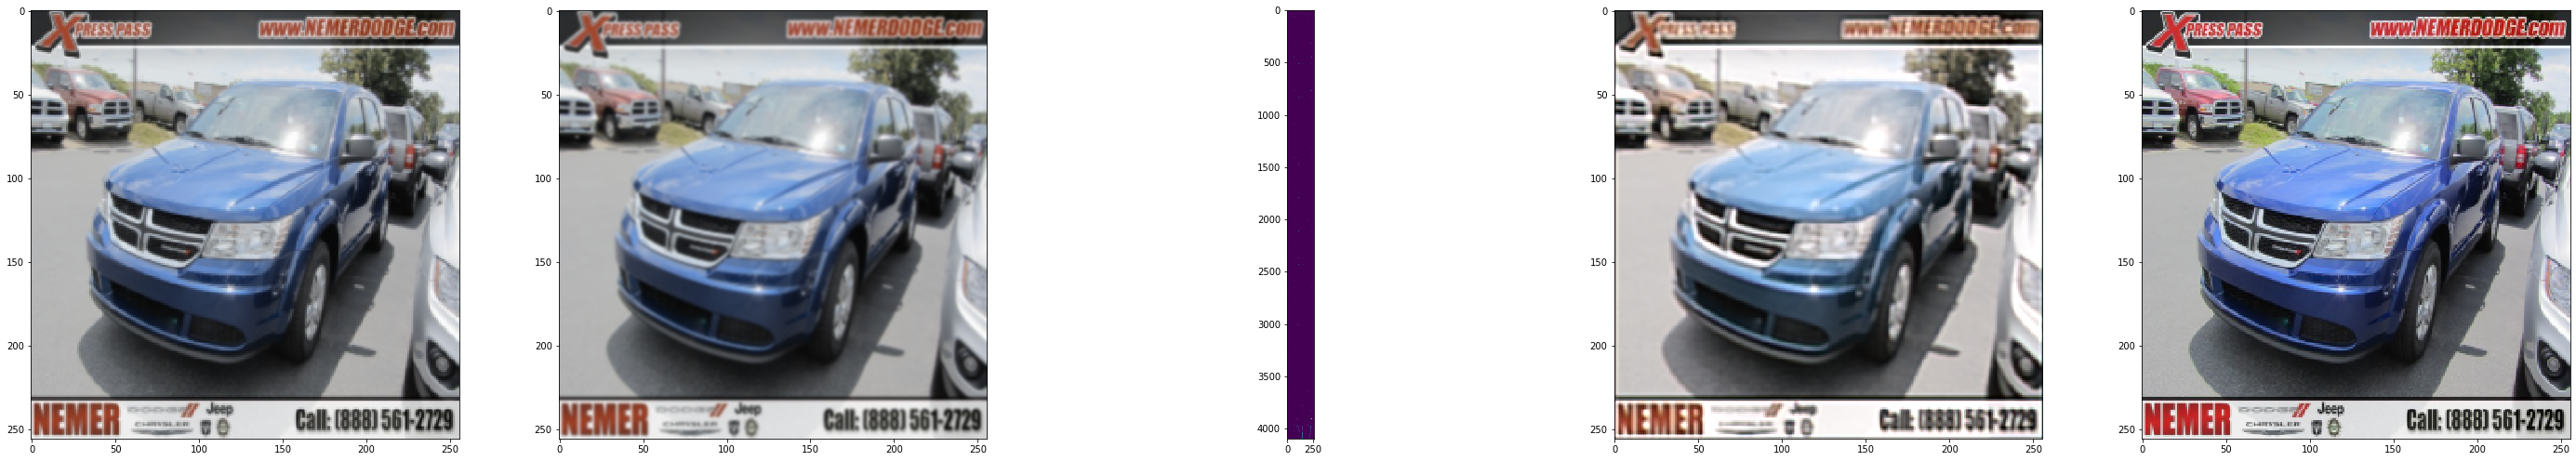

In [43]:
plt.figure(figsize = (100, 100))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index], interpolation = "bicubic")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(encoded_imgs[image_index].reshape((64*64, 256)))
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index])
plt.show()